<a href="https://colab.research.google.com/github/deanhoperobertson/Named-Enitty-Recognition/blob/master/Models/Hyperparameter%20Optimization/CRF/Conditional%20Random%20Fields%20(Grid%20Search%203).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving prepro.py to prepro.py


In [ ]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 4.0MB/s 


In [ ]:
import pandas as pd
import numpy as np
import urllib.request
import re
from collections import OrderedDict

#grid search
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

#Custom models
from prepro import *

#Model
from sklearn_crfsuite import CRF

#Evalulation
from sklearn_crfsuite.metrics import flat_f1_score

In [ ]:
#import data from my github repo
train_url = "https://raw.githubusercontent.com/deanhoperobertson/Named-Enitty-Recognition/master/Data/train.txt"
test_url = "https://raw.githubusercontent.com/deanhoperobertson/Named-Enitty-Recognition/master/Data/test.txt"
train = urllib.request.urlopen(train_url).read()
test = urllib.request.urlopen(test_url).read()
train = train.decode('utf-8')
test = test.decode('utf-8')

#preproces the txt file
train = readstring(train,"NONE")
test = readstring(test, "NONE")

## Orthographic Feature Engineering

In [ ]:
#Engineered Features:
def mix(word):
    if word.isalnum():
        if re.search("^(?=.*[a-zA-Z])(?=.*[0-9])",word): return True
        else: return False
    else:
        return False

def non_intial(word):
    '''
    The Function the boolean if a non-initial captital letter is present
    '''
    return not word[1:].islower()

def contain_punct(word):
    '''
    The Function returns the boolean if punctuations is present in token
    '''
    if re.match(r'^\w+$',word):return False
    else: return True
    
def apostrophe(word):
    '''
    The Function returns boolean if "'s" is present in token 
    '''
    if word =="'s":return True
    else:return False
    
def word_pattern(word):
    '''
    The Function returns word patter feature
    Upper Case = "A"
    Lower Case = "a"
    Digit = "0"
    '''
    token=""
    for i in word:
        if i.isupper():
            token +="A"
        elif i.islower():
            token +="a"
        elif i.isdigit():
            token +="0"
        else:
            token +=str(i)
    return token

def pattern_sum(word):
    '''
    The Function returns the word patern without consectutive duplicates
    '''
    return ''.join(OrderedDict.fromkeys(word))

In [ ]:
def word2features(sentence,i):
    word = sentence[i]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        
        'Prefix_2': word[:2], # prefix
        'Prefix_3': word[:3], # prefix
        
        'word.istitle()': word.istitle(), #starts with caps
        'word.isupper()': word.isupper(), #all caps
        'word.islower()': word.islower(), #all lower case
        'word.isdigit()': word.isdigit(), #all digits
        'word.isalpha()': word.isalpha(), #all letters
        
        'word.punct()': contain_punct(word),#contains punctuation
        'word.apost()': apostrophe(word), #is an apostrophe
        'word.non_intial': non_intial(word), #non-initial capitals
        'word.mix': mix(word), #mixture of letters and digits
        'word.pattern()': word_pattern(word), #word pattern
        'word.pattern_sum()': pattern_sum(word_pattern(word)), #word pattern summary
        
        'Suffix_2': word[-2:], # suffix
        'Suffix_3': word[-3:], # suffix
    }
    if  i == 1 :
        '''
        Get the token before in the sentence
        '''
        word1 = sentence[i-1]
        features.update({
          '-1word.lower()':word1.lower(),
          '-1Prefix_2': word1[:2],
          '-1Prefix_3': word1[:3], 
          '-1word.istitle()':word1.istitle(), 
          '-1word.isupper()':word1.isupper(), 
          '-1word.islower()':word1.islower(),
          '-1word.isdigit()':word1.isdigit(), 
          '-1word.isalpha()':word1.isalpha(), 
          '-1word.punct()': contain_punct(word1),
          '-1word.apost()': apostrophe(word1),
          '-1word.non_intial': non_intial(word1),
          '-1word.mix': mix(word1),
          '-1word.pattern()': word_pattern(word1),
          '-1word.pattern_sum()': pattern_sum(word_pattern(word1)), 
          '-1Suffix_2': word1[-2:], 
          '-1Suffix_3': word1[-3:], 
        })
        
    elif i==2:
        word1 = sentence[i-1]
        word2 = sentence[i-2]
        
        features.update({
          '-1word.lower()': word1.lower(),
          '-1Prefix_2':word1[:2],
          '-1Prefix_3':word1[:3], 
          '-1word.istitle()': word1.istitle(), 
          '-1word.isupper()': word1.isupper(), 
          '-1word.islower()': word1.islower(),
          '-1word.isdigit()': word1.isdigit(), 
          '-1word.isalpha()': word1.isalpha(), 
          '-1word.punct()': contain_punct(word1),
          '-1word.apost()': apostrophe(word1),
          '-1word.non_intial': non_intial(word1),
          '-1word.mix': mix(word1),
          '-1word.pattern()': word_pattern(word1),
          '-1word.pattern_sum()': pattern_sum(word_pattern(word1)), 
          '-1Suffix_2':word1[-2:], 
          '-1Suffix_3':word1[-3:], 
            
            
          '-2word.lower()': word2.lower(),
          '-2Prefix_2':word2[:2],
          '-2Prefix_3':word2[:3], 
          '-2word.istitle()': word2.istitle(), 
          '-2word.isupper()': word2.isupper(), 
          '-2word.islower()': word2.islower(),
          '-2word.isdigit()': word2.isdigit(), 
          '-2word.isalpha()': word2.isalpha(), 
          '-2word.punct()': contain_punct(word2),
          '-2word.apost()': apostrophe(word2),
          '-2word.non_intial': non_intial(word2),
          '-2word.mix': mix(word2),
          '-2word.pattern()': word_pattern(word2),
          '-2word.pattern_sum()': pattern_sum(word_pattern(word2)), 
          '-2Suffix_2':word2[-2:], 
          '-2Suffix_3':word2[-3:], 
        })
        
    elif i>2:
        word1 = sentence[i-1]
        word2 = sentence[i-2]
        word3 = sentence[i-3]
        
        features.update({
          '-1word.lower()': word1.lower(),
          '-1Prefix_2':word1[:2],
          '-1Prefix_3':word1[:3], 
          '-1word.istitle()': word1.istitle(), 
          '-1word.isupper()': word1.isupper(), 
          '-1word.islower()': word1.islower(),
          '-1word.isdigit()': word1.isdigit(), 
          '-1word.isalpha()': word1.isalpha(), 
          '-1word.punct()': contain_punct(word1),
          '-1word.apost()': apostrophe(word1),
          '-1word.non_intial': non_intial(word1),
          '-1word.mix': mix(word1),
          '-1word.pattern()': word_pattern(word1),
          '-1word.pattern_sum()': pattern_sum(word_pattern(word1)), 
          '-1Suffix_2':word1[-2:], 
          '-1Suffix_3':word1[-3:], 
            
            
          '-2word.lower()': word2.lower(),
          '-2Prefix_2':word2[:2],
          '-2Prefix_3':word2[:3], 
          '-2word.istitle()': word2.istitle(), 
          '-2word.isupper()': word2.isupper(), 
          '-2word.islower()': word2.islower(),
          '-2word.isdigit()': word2.isdigit(), 
          '-2word.isalpha()': word2.isalpha(), 
          '-2word.punct()': contain_punct(word2),
          '-2word.apost()': apostrophe(word2),
          '-2word.non_intial': non_intial(word2),
          '-2word.mix': mix(word2),
          '-2word.pattern()': word_pattern(word2),
          '-2word.pattern_sum()': pattern_sum(word_pattern(word2)), 
          '-2Suffix_2':word2[-2:], 
          '-2Suffix_3':word2[-3:], 
            
          '-3word.lower()': word3.lower(),
          '-3Prefix_2':word3[:2],
          '-3Prefix_3':word3[:3], 
          '-3word.istitle()': word3.istitle(), 
          '-3word.isupper()': word3.isupper(), 
          '-3word.islower()': word3.islower(),
          '-3word.isdigit()': word3.isdigit(), 
          '-3word.isalpha()': word3.isalpha(), 
          '-3word.punct()': contain_punct(word3),
          '-3word.apost()': apostrophe(word3),
          '-3word.non_intial': non_intial(word3),
          '-3word.mix': mix(word3),
          '-3word.pattern()': word_pattern(word3),
          '-3word.pattern_sum()': pattern_sum(word_pattern(word3)), 
          '-3Suffix_2':word3[-2:], 
          '-3Suffix_3':word3[-3:], 
        })
        
    else:
        features['Start'] = True
        
    if i == len(sentence)-2:
        '''
        Get the token after in the sentence
        '''
        word1 = sentence[i+1]
        features.update({
          '+1word.lower()': word1.lower(),
          '+1Prefix_2':word1[:2],
          '+1Prefix_3':word1[:3], 
          '+1word.istitle()': word1.istitle(), 
          '+1word.isupper()': word1.isupper(), 
          '+1word.islower()': word1.islower(),
          '+1word.isdigit()': word1.isdigit(), 
          '+1word.isalpha()': word1.isalpha(), 
          '+1word.punct()': contain_punct(word1),
          '+1word.apost()': apostrophe(word1),
          '+1word.non_intial': non_intial(word1),
          '+1word.mix': mix(word1),
          '+1word.pattern()': word_pattern(word1),
          '+1word.pattern_sum()': pattern_sum(word_pattern(word1)), 
          '+1Suffix_2':word1[-2:], 
          '+1Suffix_3':word1[-3:], 
        })
        
    elif i == len(sentence)-3:
        word1 = sentence[i+1]
        word2 = sentence[i+2]
        
        features.update({
          '+1word.lower()': word1.lower(),
          '+1Prefix_2':word1[:2],
          '+1Prefix_3':word1[:3], 
          '+1word.istitle()': word1.istitle(), 
          '+1word.isupper()': word1.isupper(), 
          '+1word.islower()': word1.islower(),
          '+1word.isdigit()': word1.isdigit(), 
          '+1word.isalpha()': word1.isalpha(), 
          '+1word.punct()': contain_punct(word1),
          '+1word.apost()': apostrophe(word1),
          '+1word.non_intial': non_intial(word1),
          '+1word.mix': mix(word1),
          '+1word.pattern()': word_pattern(word1),
          '+1word.pattern_sum()': pattern_sum(word_pattern(word1)), 
          '+1Suffix_2':word1[-2:], 
          '+1Suffix_3':word1[-3:], 
            
          '+2word.lower()': word2.lower(),
          '+2Prefix_2':word2[:2],
          '+2Prefix_3':word2[:3], 
          '+2word.istitle()': word2.istitle(), 
          '+2word.isupper()': word2.isupper(), 
          '+2word.islower()': word2.islower(),
          '+2word.isdigit()': word2.isdigit(), 
          '+2word.isalpha()': word2.isalpha(), 
          '+2word.punct()': contain_punct(word2),
          '+2word.apost()': apostrophe(word2),
          '+2word.non_intial': non_intial(word2),
          '+2word.mix': mix(word2),
          '+2word.pattern()': word_pattern(word2),
          '+2word.pattern_sum()': pattern_sum(word_pattern(word2)), 
          '+2Suffix_2':word2[-2:], 
          '+2Suffix_3':word2[-3:], 
        })
        
    elif i < len(sentence)-3:
        word1 = sentence[i+1]
        word2 = sentence[i+2]
        word3 = sentence[i+3]
        
        features.update({
          '+1word.lower()': word1.lower(),
          '+1Prefix_2':word1[:2],
          '+1Prefix_3':word1[:3], 
          '+1word.istitle()': word1.istitle(), 
          '+1word.isupper()': word1.isupper(), 
          '+1word.islower()': word1.islower(),
          '+1word.isdigit()': word1.isdigit(), 
          '+1word.isalpha()': word1.isalpha(), 
          '+1word.punct()': contain_punct(word1),
          '+1word.apost()': apostrophe(word1),
          '+1word.non_intial': non_intial(word1),
          '+1word.mix': mix(word1),
          '+1word.pattern()': word_pattern(word1),
          '+1word.pattern_sum()': pattern_sum(word_pattern(word1)), 
          '+1Suffix_2':word1[-2:], 
          '+1Suffix_3':word1[-3:], 
            
          '+2word.lower()': word2.lower(),
          '+2Prefix_2':word2[:2],
          '+2Prefix_3':word2[:3], 
          '+2word.istitle()': word2.istitle(), 
          '+2word.isupper()': word2.isupper(), 
          '+2word.islower()': word2.islower(),
          '+2word.isdigit()': word2.isdigit(), 
          '+2word.isalpha()': word2.isalpha(), 
          '+2word.punct()': contain_punct(word2),
          '+2word.apost()': apostrophe(word2),
          '+2word.non_intial': non_intial(word2),
          '+2word.mix': mix(word2),
          '+2word.pattern()': word_pattern(word2),
          '+2word.pattern_sum()': pattern_sum(word_pattern(word2)), 
          '+2Suffix_2':word2[-2:], 
          '+2Suffix_3':word2[-3:], 
            
          '+3word.lower()': word3.lower(),
          '+3Prefix_2':word3[:2],
          '+3Prefix_3':word3[:3], 
          '+3word.istitle()': word3.istitle(), 
          '+3word.isupper()': word3.isupper(), 
          '+3word.islower()': word3.islower(),
          '+3word.isdigit()': word3.isdigit(), 
          '+3word.isalpha()': word3.isalpha(), 
          '+3word.punct()': contain_punct(word3),
          '+3word.apost()': apostrophe(word3),
          '+3word.non_intial': non_intial(word3),
          '+3word.mix': mix(word3),
          '+3word.pattern()': word_pattern(word3),
          '+3word.pattern_sum()': pattern_sum(word_pattern(word3)), 
          '+3Suffix_2':word3[-2:], 
          '+3Suffix_3':word3[-3:], 
        })
        
        
    else:
        features['End'] = True
    
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def get_all_sentences(dataset):
    sentences=[]
    for i in range(len(dataset)):
        sentences.append(get_sentence(dataset,i+1))
    return sentences

def get_all_labels(dataset):
    labels=[]
    for i in range(len(dataset)):
        #labels.append(partial_tags(get_label(dataset,i+1)))
        labels.append(get_label(dataset,i+1))
    return labels

In [ ]:
#Apply feature engineering
train_sents = get_all_sentences(train)
train_labels = get_all_labels(train)
test_sents = get_all_sentences(test)
test_labels = get_all_labels(test)

X_train = [sent2features(s) for s in train_sents]
y_train = train_labels
X_test = [sent2features(s) for s in test_sents]
y_test = test_labels


sub_labels=list(set([item for sublist in train_labels for item in sublist]))
sub_labels.remove("O")

NameError: ignored

## Grid Search



In [ ]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=10,
    all_possible_transitions=False
)

c1_c2= tuple(round(i,2) for i in list(np.linspace(0,1,11)))


parameters = {'c1':c1_c2,
             'c2': c1_c2}

f1_scorer = make_scorer(flat_f1_score,
                        average='micro',
                        labels=sub_labels)

grid = GridSearchCV(crf, 
                    parameters,
                    n_jobs=-1,
                    scoring =f1_scorer,
                    verbose=2,
                    return_train_score=True,
                    cv=3)

In [ ]:
%%time
grid_results=grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Fitting 3 folds for each of 121 candidates, totalling 363 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 193.7min
[Parallel(n_jobs=-1)]: Done 363 out of 363 | elapsed: 459.5min finished


CPU times: user 7h 32min 29s, sys: 6min 11s, total: 7h 38min 41s
Wall time: 7h 40min 7s


In [ ]:
print('best params:', grid_results.best_params_)
print('best CV score:',grid_results.best_score_)

means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

best params: {'c1': 0.1, 'c2': 0.5}
best CV score: 0.6272810587730392
0.610406 (0.028726) with: {'c1': 0.0, 'c2': 0.0}
0.610402 (0.028705) with: {'c1': 0.0, 'c2': 0.1}
0.610398 (0.028685) with: {'c1': 0.0, 'c2': 0.2}
0.610416 (0.028680) with: {'c1': 0.0, 'c2': 0.3}
0.610416 (0.028680) with: {'c1': 0.0, 'c2': 0.4}
0.610366 (0.028751) with: {'c1': 0.0, 'c2': 0.5}
0.610352 (0.028767) with: {'c1': 0.0, 'c2': 0.6}
0.610339 (0.028758) with: {'c1': 0.0, 'c2': 0.7}
0.610329 (0.028795) with: {'c1': 0.0, 'c2': 0.8}
0.610349 (0.028853) with: {'c1': 0.0, 'c2': 0.9}
0.610329 (0.028839) with: {'c1': 0.0, 'c2': 1.0}
0.627019 (0.022027) with: {'c1': 0.1, 'c2': 0.0}
0.627019 (0.022027) with: {'c1': 0.1, 'c2': 0.1}
0.627019 (0.022027) with: {'c1': 0.1, 'c2': 0.2}
0.627138 (0.022095) with: {'c1': 0.1, 'c2': 0.3}
0.627169 (0.022000) with: {'c1': 0.1, 'c2': 0.4}
0.627281 (0.022063) with: {'c1': 0.1, 'c2': 0.5}
0.627281 (0.022063) with: {'c1': 0.1, 'c2': 0.6}
0.627177 (0.022035) with: {'c1': 0.1, 'c2': 0.7}

In [ ]:
Results=pd.DataFrame(grid_results.cv_results_)
Results=Results.sort_values(by=["mean_test_score"])

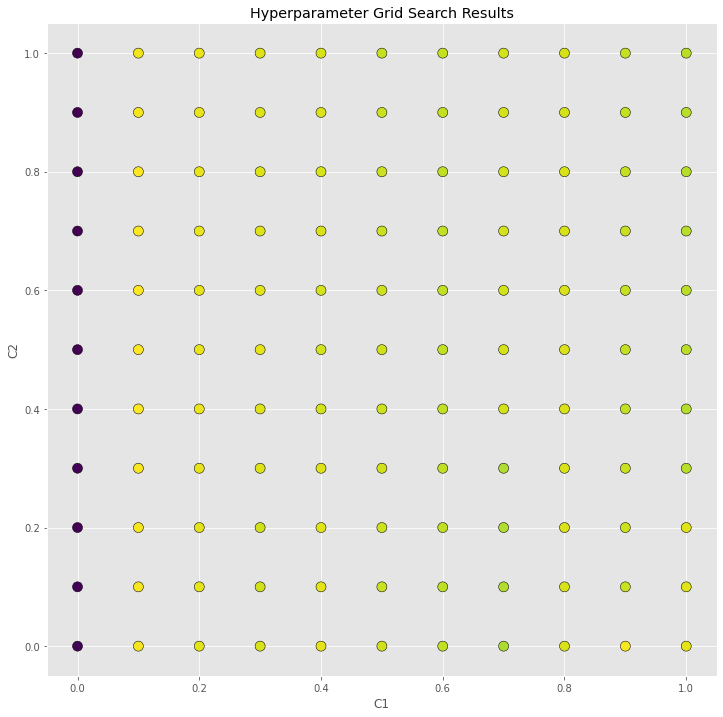

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
plt.style.use('ggplot')

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_xlabel('C1')
ax.set_ylabel('C2')

_x = list(Results["param_c1"])
_y = list(Results["param_c2"])
_f1 = list(Results["mean_test_score"])

ax.set_title("Hyperparameter Grid Search Results")

#norm_1 = colors.LogNorm(vmin=min(_f1),vmax=max(_f1))

ax.scatter(_x, _y, c=_f1, s=100, alpha=1, edgecolors=[0,0,0], norm=colors.LogNorm()) #PowerNorm
c1 = grid_results.best_params_["c1"]
c2 = grid_results.best_params_["c2"]
#ax.scatter(c1,c2,color="red", s=100)

In [ ]:
from google.colab import files
Results.to_csv('Grid_3.csv')
files.download('Grid_3.csv')

In [ ]:
fig.savefig('Grid_3.png')
files.download('Grid_3.png') 